# Attention

Embedding + BiLSTM 모델과 추가로 Seq2seq을 구성하여 Attention 층을 추가
## 1. 감정 분류을 위한 Attention 순환 신경망: BiLSTM + Attention

기존 Embedding + BiLSTM 모델 아키텍처에 Bahdanau Attention(Additive)을 추가

BiLSTM 층을 통과해 나온 특성 벡터를 폴링 하지 않고 Attention을 통해 문장 전체에서 가장 중요한 토큰들의 정보가 압축된 컨텍스트 벡터(context vector)를 만듦


### 단계:

1. 모델 정의: BiLSTMWithAttention 클래스를 만듭니다.

2. 데이터 준비: AIHUB 감성 대화 데이터를 로드합니다.

3. 토크나이저: SentencePiece (BPE) 토크나이저를 학습시킵니다.

4. 데이터셋/로더: PyTorch Dataset 및 DataLoader를 구축합니다.

5. 학습 및 평가: 모델을 학습시키고, 손실 및 정확도 변화를 시각화하여 어텐션의 효과를 확인합니다.

### 모델링

**임베딩 레이어 사용**
- 토큰의 정수 인덱스로 부터 Embedding 레이어를 통 정수를 해당하는 임베딩 벡터로 매핑

**Bi-LSTM (Bidirectional LSTM) 레이어**
- 입력된 임베딩 벡터를 시간 축을 따라 처리하여, 시퀀스 데이터의 문맥 정보를 학습
- 양방향 LSTM은 입력 데이터를 과거와 미래 방향으로 모두 처리해 더 풍부한 문맥 정보를 캡처

**어텐션 적용(Bahdanau Attention)**
- 일반적인 LSTM은 마지막 타임스텝의 hidden state만을 사용하거나, 모든 hidden state를 단순 평균
- LSTM이 출력한 각 타임스텝의 hidden state를 평가하여, 시퀀스에서 중요한 단어(정보)에 더 높은 가중치를 부여
- 모델은 높은 가중치를 가진 중요한 단어에 집중하여 결과를 예측

- 어텐션 과정

$$u_t = \tanh(W_{\text{att}} \cdot h_t)$$


$$a_t = \text{softmax}(W_c \cdot u_t)$$

$$c = \sum_t a_t \cdot h_t$$


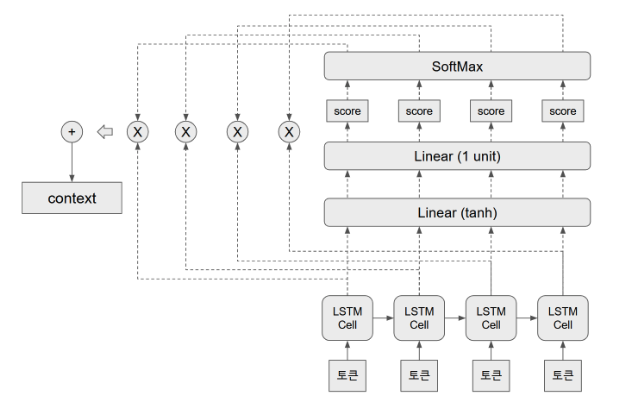

    1. 선형 변환 이후 tanh 활성화를 통해 어텐션 스코어를 계산하기 위한 중간 표현(u)을 생성
    2. u를 단일 유닛으로 변환하여 각의 토큰 위치에 대한 스칼라 가중치(로짓)를 뽑아냄
    3. 로짓을 소프트맥스 활성화 하여 각 토큰 위치에 대한 확률 분포인 어텐션 가중치(a)를 생성
    5. 어텐션 가중치(a)는 한 문장 내에서 가장 중요한 토큰에는 높은 값이 할당됨
    6. 시퀀스 차원의 토큰 벡터 out에 어텐션 가중치 a를 각각 곱하고 가중합(Weighted Sum) 하여, 컨텍스트 벡터(Context Vecto)를 구함
    7. 산출된 컨텍스트 벡터에는 각 배치별로 문장 전체에서 가장 중요한 토큰들의 정보가 압축



In [12]:
import torch
import torch.nn as nn

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=12, num_layers=4, num_classes=2):
        super(BiLSTMWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self. lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # 어텐션 레이어
        self.attention = nn.Linear(hidden_size*2, hidden_size*2) # 양방향이므로 hidden_size * 2
        self.context_vector = nn.Linear(hidden_size * 2, 1, bias=False)

        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(p=0.2)

        # 출력 레이어 num_classes로 출력
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 임베딩 레이어
        x = self.embedding(x)     # [batch_size, seq_len, embedding_dim]

        # 양방향 LSTM 순전파
        out, _ = self.lstm(x)     # out: [batch_size, seq_len, hidden_size * 2]
        print(f'lstm: {out.shape}')

        # 어텐션 메커니즘 적용
        u = torch.tanh(self.attention(out))               # [batch_size, seq_len, hidden_size * 2]
        print(f'u: {u.shape}')
        a = torch.softmax(self.context_vector(u), dim=1)  # [batch_size, seq_len, 1]
        print(f'a: {a.shape}')

        context = (a * out).sum(dim=1)  # [batch_size, hidden_size * 2]
        print(f'context : {context.shape}')

        # 출력 레이어를 통해 최종 출력
        context = self.layer_norm(context)
        context = self.dropout(context)
        dense = self.fc1(context)
        out = self.fc2(dense)           # [batch_size, num_classes]

        return out
    
# 모델 생성
model = BiLSTMWithAttention(vocab_size=100, embedding_dim=32)
input = torch.tensor([1,2,3,4]) # 임의의 토큰
output = model(input.unsqueeze(0))
print(f'모델 출력 결과: {output}')

lstm: torch.Size([1, 4, 24])
u: torch.Size([1, 4, 24])
a: torch.Size([1, 4, 1])
context : torch.Size([1, 24])
모델 출력 결과: tensor([[ 0.2605, -0.5975]], grad_fn=<AddmmBackward0>)


### 모델 학습

[AIHUB](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=86)에서 제공하는 한국어 감성 대화 말뭉치 데이터세트를 부분적으로 활용하여 감정 분류 학습

In [13]:
with open("train.csv", "r", encoding="utf-8") as f:
    text = f.read()

In [14]:
import pandas as pd
import numpy as np
import sentencepiece as spm
import torch
import torch.nn as nn


df = pd.read_csv(f'./train.csv')
sent_df = df[['label','HS01']].rename({'HS01':'text'},axis = 1).dropna()
sent_df

,label,text
0,E1,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,E1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,E1,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,E1,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,E1,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
...,...,...
51623,E1,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.
51624,E3,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.
51625,E4,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.
51626,E3,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.


In [21]:
import sentencepiece as spm
import pandas as pd
import os

bpe_path = f'bpe'

# bpe 모델을 저장할 디렉터리 생성
os.makedirs(bpe_path, exist_ok=True)

# 훈련시킬 텍스트 데이터를 담을 파일
corpus_file = f'{bpe_path}/krsent_corpus.txt'

try:
  # CSV 파일 다시 읽기 (HS01: 질문, SS01: 답변)
  df = pd.read_csv(f'./train.csv')
  df = df[['HS01', 'SS01']].dropna()

  print("코퍼스 파일 생성 중...")
  # 질문(HS01)과 답변(SS01) 텍스트를 모두 합쳐서 하나의 텍스트 파일로 저장
  with open(corpus_file, 'w', encoding='utf-8') as f:
    for text in df['HS01']:
      f.write(f"{text}\n")
    for text in df['SS01']:
      f.write(f"{text}\n")

  print(f"코퍼스 파일 저장 완료: {corpus_file}")

  # --- SentencePiece 모델 훈련 ---

  # 노트북의 SPDataSet(cell 18)과 CrossEntropyLoss(cell 20)를 분석한 결과,
  # [PAD]=0, [UNK]=1, [BOS]=2, [EOS]=3 토큰 ID를 사용해야 합니다.

  model_prefix = f'{bpe_path}/spm_krsent'
  vocab_size = 8000  # 어휘 크기 (조정 가능)

  spm_command = (
      f'--input={corpus_file} '
      f'--model_prefix={model_prefix} '
      f'--vocab_size={vocab_size} '
      f'--model_type=bpe '      # BPE 모델 사용
      f'--pad_id=0 '            # 패딩 토큰 ID
      f'--unk_id=1 '            # 알 수 없는 토큰 ID
      f'--bos_id=2 '            # 문장 시작 토큰 ID
      f'--eos_id=3 '            # 문장 끝 토큰 ID
      f'--pad_piece=[PAD] '     # 패딩 토큰 문자
      f'--unk_piece=[UNK] '     # 알 수 없는 토큰 문자
      f'--bos_piece=[BOS] '     # 문장 시작 토큰 문자
      f'--eos_piece=[EOS]'      # 문장 끝 토큰 문자
  )

  print("SentencePiece 모델 훈련 시작...")
  spm.SentencePieceTrainer.train(spm_command)

  print(f"모델 훈련 완료! 모델이 {model_prefix}.model 에 저장되었습니다.")

except FileNotFoundError:
  print(f"오류: train.csv 파일을 찾을 수 없습니다.")


코퍼스 파일 생성 중...
코퍼스 파일 저장 완료: bpe/krsent_corpus.txt
SentencePiece 모델 훈련 시작...
모델 훈련 완료! 모델이 bpe/spm_krsent.model 에 저장되었습니다.


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=bpe/krsent_corpus.txt --model_prefix=bpe/spm_krsent --vocab_size=8000 --model_type=bpe --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: bpe/krsent_corpus.txt
  input_format: 
  model_prefix: bpe/spm_krsent
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  trai

### SentencePiece 토크나이저를 이용해서 만든 PyTorch Dataset 클래스

In [22]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import sentencepiece as spm
import torch
import torch.nn as nn

class SPDataSet(Dataset):
    def __init__(self, df, sp, max_len):
        self.max_len = max_len
        self.df = df
        self.sp = sp
        self.class_name = {'E1':0, 'E6':1, 'E3':2, 'E5':3, 'E2':4, 'E4':5}

    def zero_pad(self, tok):
        if len(tok) >= self.max_len:
            return tok[:self.max_len]
        else:
            padding = np.zeros(self.max_len)
            padding[:len(tok)] = tok
            return padding
    
    def __getitem__(self, i):
        inp = str(self.df.iloc[i]['text'])
        tar = self.df.iloc[i]['label']
        # 라벨 인코딩
        tar = self.class_name[tar]
        # 문장 인코딩 (앞뒤오 시작토큰과 끝 토큰을 붙임)
        inp = [self.sp.bos_id()] + self.sp.encode_as_ids(inp) + [self.sp.eos_id()]
        # 패딩
        inp = self.zero_pad(inp)

        return torch.Tensor(inp), tar

    def __len__(self):
        return (len(self.df))

### 모델이 학습하기 전에 학습 파이프라인 전체를 준비하는 과정

In [23]:
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import sentencepiece as spm
import torch


# 하이퍼파라미터 설정
embedding_dim = 128     # 임베딩 차원
max_len = 60
hidden_size = 256       # LSTM 은닉 상태 크기
num_layers = 2          # LSTM 레이어 수
num_classes = 6         # 출력 클래스 수 긍정/부정
learning_rate = 0.0001
num_epochs = 20
batch_size = 64
sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
vocab_size = sp.get_piece_size()

# 모델 초기화
model = BiLSTMWithAttention(vocab_size, embedding_dim, hidden_size, num_layers, num_classes)

# 데이터세트 분할
dataset = SPDataSet(sent_df, sp, max_len)

generator1 = torch.Generator().manual_seed(42)
test_dataset, train_dataset = random_split(dataset, [0.2, 0.8], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

### 모델 학습(train) + 평가(validation) 단계

In [33]:
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {'train_loss': [],
           'val_loss': [],
           'val_acc': []
           }

for epoch in range(num_epochs):
  model.train() # 모델을 학습모드로 설정
  total_loss = 0.0

  for input, labels in train_loader:
    # 입력데이터 준비
    input_ids = input.long().to(device) # [batch_size, seq_len]
    labels = labels.to(device)
    # 순전파
    outputs = model(input_ids)          # [batch_size, num_calsses]
    loss = criterion(outputs, labels)   # 손실 계산

    # 역전파 및 옵티마아지 업데이트
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  history['train_loss'].append(avg_loss)
  # 에폭별 손실 출력
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

  # 평가 과정
  model.eval()
  total_val_loss = 0.0
  total_val_acc = 0.0

  with torch.no_grad():  # 평가 과정에서는 그래디언트를 계산하지 않음
    for input, labels in val_loader:
        # 입력 데이터 준비
        input_ids = input.long().to(device)  # [batch_size, seq_len]
        labels = labels.to(device)  # [batch_size]

        # 순전파
        outputs = model(input_ids)  # [batch_size, num_classes]
        loss = criterion(outputs, labels)  # 손실 계산
        total_val_loss += loss.item()
        acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)
        total_val_acc += acc

  # 손실 및 정확도 계산
  avg_val_loss = total_val_loss / len(val_loader)
  avg_val_acc = total_val_acc / len(val_loader)
  history['val_loss'].append(avg_val_loss)
  history['val_acc'].append(avg_val_acc.cpu().numpy())
  # 평가 결과 출력
  print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.4f}")


lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch.Size([64, 60, 512])
a: torch.Size([64, 60, 1])
context : torch.Size([64, 512])
lstm: torch.Size([64, 60, 512])
u: torch

> 단순 RNN 위에 Attention을 추가했을때 성능 향상은 있지만 여전히 과적합에는 취약하다


## 2. Seq2seq + Attention (질의응답 챗봇)

간단한 Seq2seq 모델을 구축하여 질의로 부터 응답을 생성해내는 모델 아케텍처를 만듭니다.

이때 Attention을 추가하여 입력 시퀀스의 각 토큰에 대한 중요도를 계산하여 모든 토큰을 균등하게 처리하는 것이 아니라, 중요한 토큰에 더 집중할 수 있게 합니다.

### 단계:

1. 모델 정의 (Encoder): 입력 문장을 인코딩하는 Encoder 클래스를 만듭니다.

2. 모델 정의 (Decoder): 인코더의 정보와 어텐션을 활용해 응답을 생성하는 Decoder 클래스를 만듭니다.

3. 데이터셋/로더: Seq2seq용 Dataset을 만듭니다. (입력: 질문, 타겟: [BOS] + 응답 + [EOS])

4. 학습 (Teacher Forcing): '교사 강요(Teacher Forcing)' 방식을 사용하여 Seq2seq 모델을 학습시킵니다.

5. 추론 (Inference): 학습된 모델로 실제 새로운 문장을 생성(Greedy Search)해봅니다.

### 모델링

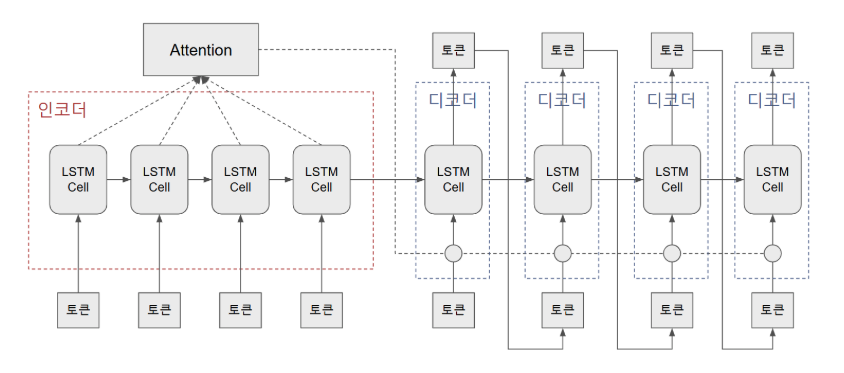


**인코더(Encoder)**
- 입력 시퀀스를 임베딩 후 양방향 LSTM으로 인코딩, 전체 은닉 상태들을 출력

**디코더(Decoder)**
- 이전 시점의 단어(또는 임베딩)와 은닉 상태로 새로운 은닉 상태를 만든 뒤, 인코더 은닉 상태와 어텐션을 통해 컨텍스트 벡터를 구해 최종 출력

**어텐션**
- Bahdanau 어텐션 형태의 단순 버전으로, 인코더 출력을 디코더 은닉 상태에 맞춰 가중합


#### 인코더 구성

인코더는 입력된 텍스트에 대한 가중치를 만들어내는 작업만 진행하기 때문에 기존 임베딩+RNN 모델 구조와 유사하게 구현됩니다.

디코더와 연결을 위해 LSTM의 출력 결과와 히든 상태를 전부 return 합니다.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as f

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=128, num_layers=1, dropout=0.1):
        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [batch_size, seq_len, embedding_dim]
        outputs, (h, c) = self.lstm(embedded)  # outputs: [batch_size, seq_len, hidden_size]
        return outputs, h, c
    
# encoder check
encoder = Encoder(vocab_size=100, embedding_dim=32, num_layers=3)
input = torch.tensor([1,2,3,4])     # 임의의 토큰
enc_out, h, c = encoder(input.unsqueeze(0))
print(f'인코더 출력 결과: {enc_out.shape}')
print(f'인코더 히든 상태: {h.shape}')

인코더 출력 결과: torch.Size([1, 4, 128])
인코더 히든 상태: torch.Size([3, 1, 128])


#### 디코더 구성

디코더는 생성 하고자 하는 문장의 직적 토큰으로 부터 다음 토큰을 생성하는 역할을 합니다.

이때 인코더가 만들어낸 입력 텍스트의 순환특성과 함께 직전 토큰을 입력 받아 새로운 토큰을 만들어 냅니다.

기본적인 LSTM(또는 GRU) 구조만 가지고 있을땐 인코더의 히든 상태를 디코더의 토큰이 들어가는 LSTM이 이어 받아 사용합니다.

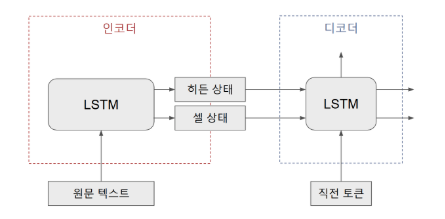


Attention 기법을 추가하면 디코더는 인코더의 모든 시퀀스 결과 값과 마지막 시퀀스의 히든 상태를 Bahdanau Attention하여 컨텍스트 벡터를 만들어냅니다.
만들어진 컨텍스트 벡터는 디코더의 입력 토큰 임베딩과 concat 하여 디코더 LSTM 구조에 입력합니다.

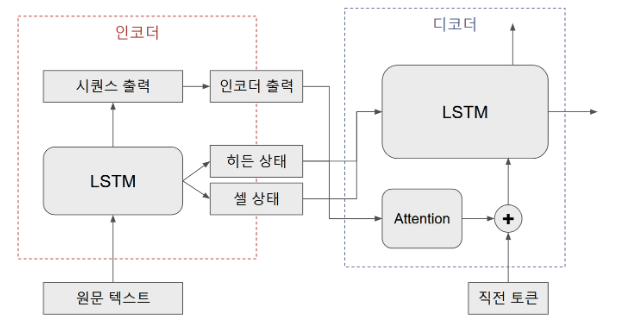


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import e

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=128, num_layers=1, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim + hidden_size,  # 디코더 입력: [이전 단어 임베딩 + 컨텍스트 벡터]
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        # Bahdanau(가산) 어텐션 레이어와 컨텍스트 벡터 계산
        self.attention1 = nn.Linear(hidden_size, hidden_size)
        self.attention2 = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

        # 최종 출력 (단어 분포)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size

    def forward(self, input_token, hidden, cell, encoder_outputs):

        # 어텐션 가중치 계산
        dec_hidden = hidden[-1]  # 마지막 층의 히든 상태를 가져옴 [batch_size, hidden_size]
        dec_hidden = dec_hidden.unsqueeze(1) # seq_len에 해당하는 축 생성 [batch_size, 1, hidden_size]

        dec_u = self.attention1(dec_hidden) # [batch_size, 1, hidden_size]
        enc_u = self.attention2(encoder_outputs) # [batch_size, seq_len, hidden_size]
        concat_inputs = dec_u + enc_u  # [batch_size, seq_len, hidden_size]

        score = self.v(torch.tanh(concat_inputs)) # [batch_size, seq_len, 1]
        a = F.softmax(score, dim=1)

        # 컨텍스트 벡터 생성

        context = torch.sum(a * encoder_outputs, dim=1)  # [batch_size, hidden_size]

        # 현재 단어 임베딩
        input_token = input_token.unsqueeze(1)  # [batch_size, 1]
        embedded = self.embedding(input_token)  # [batch_size, 1, embedding_dim]

        # LSTM 입력 (embedded + context)
        # embedded: [batch_size, 1, embedding_dim]
        # context:  [batch_size, hidden_size]
        context = context.unsqueeze(1) # [batch_size, 1, hidden_size]
        dec_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, embedding_dim + hidden_size]

        # 디코더 LSTM
        # out: [batch_size, 1, hidden_size]
        # hidden, cell: [num_layers, batch_size, hidden_size]
        out, (hidden, cell) = self.lstm(dec_input, (hidden, cell))

        # # 6) 출력 단어 분포
        # out: [batch_size, 1, hidden_size] -> [batch_size, hidden_size]
        out = out.squeeze(1)
        out = self.dropout(out)
        # 최종 예측 로짓
        output = self.fc_out(out)  # [batch_size, vocab_size]

        return output, hidden, cell

# 디코더 확인
decoder = Decoder(vocab_size=100,embedding_dim=32, num_layers=3)
input = torch.tensor([2]) # 임의의 토큰
output, h, c  = decoder(input, h, c, enc_out)
print(f'인코더 출력 결과: {output.shape}')
print(f'인코더 히든 상태: {h.shape}')

인코더 출력 결과: torch.Size([1, 100])
인코더 히든 상태: torch.Size([3, 1, 128])


In [36]:
import pandas as pd

df = pd.read_csv(f'train.csv')
# HS01: 질의, SS01: 응답
df[['HS01','SS01']]

,HS01,SS01
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...
...,...,...
51623,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.
51624,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.
51625,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.
51626,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.


In [37]:
from torch.utils.data import Dataset, DataLoader, random_split
import sentencepiece as spm
import numpy as np

class SPDataSet(Dataset):
    def __init__(self, sp, max_len):
        self.max_len = max_len
        self.df = pd.read_csv(f'train.csv')[['HS01','SS01']]
        self.sp = sp

    # 제로 패딩
    def zero_pad(self, tok):
        if len(tok) >= self.max_len:
            return tok[:self.max_len]
        else:
            padding = np.zeros(self.max_len)
            padding[:len(tok)] = tok
            return padding

    def __len__(self):
        return (len(self.df))

    def __getitem__(self, i):
        sent = self.df.iloc[i]
        sent1 = self.sp.encode_as_ids(sent['HS01'])
        sent2 = self.sp.encode_as_ids(sent['SS01'])

        # 질의는 단어 토큰만 활용
        inp = self.zero_pad(sent1)
        # 응답에는 시작 토큰과 끝 토큰을 추가하여 문장의 시작과 끝을 알림
        tar = self.zero_pad([self.sp.bos_id()] + sent2 + [self.sp.eos_id()])

        return torch.Tensor(inp), torch.Tensor(tar)


sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
dataset = SPDataSet(sp, 60)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for inp, tar in dataloader:
    print(f'질문 토큰 : {inp.long()[0]}')
    print(f'응답 토큰 : {tar.long()[0]}')
    break

질문 토큰 : tensor([3246,  848,   15, 7242,  463,  129,  610,  897, 7077, 4838, 2919, 7045,
         480, 7045,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
응답 토큰 : tensor([   2,  129,  610,  397, 4838, 2216,  295, 7045,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


#### 모델 학습

Seq2seq 모델은 구성한 Eencoder와 Decoder를 동시학습 합니다.


**학습 프로세스**   

    1. 입력 데이터인 질문 토큰을 인코더에 입력
    2. 인코더의 출력과 히든 상태, 셀 상태를 디코더의 초기 입력으로 설정
    3. 디코더는 타겟 데이터인 응답 토큰이 모두 생성될 때 까지 반복하여 토큰을 생성
    4. 디코더에 인코더 출력, 히든 상태, 셀 상태가 입력하여 얻은 디코더 출력 토큰, 히든 상태, 셀 상태를 다음 디코더 입력으로 설정하여 반복
    5. 매 반복마다 손실을 누적 연산하고 반복이 끝나면 역전파를 진행

In [38]:
import torch.optim as optim

# 하이퍼파라미터 설정
embedding_dim = 128
max_len = 60
hidden_size = 256
num_layers = 4
learning_rate = 1e-4
num_epochs = 50
batch_size = 64
sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
vocab_size = sp.get_piece_size()

# 모델 초기화
encoder = Encoder(vocab_size, embedding_dim, hidden_size, num_layers)
decoder = Decoder(vocab_size, embedding_dim, hidden_size, num_layers)

# 간략한 실험을 위해 평가데이터 분리 생략
dataset = SPDataSet(sp, max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f'train dataset size: {len(dataset)}')

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
decoder = decoder.to(device)

# 패딩 토큰을 무시하는 손실
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
# 두 파라미터 리스트를 합쳐서 단일 옵티마이저 생성
encoder_params = list(encoder.parameters())
decoder_params = list(decoder.parameters())
optimizer = torch.optim.Adam(encoder_params + decoder_params, lr=learning_rate)

train dataset size: 51628


In [39]:
for e in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0.0
    for i, (inp, tar) in enumerate(dataloader):
        inp = inp.long().to(device)
        tar = tar.long().to(device)

        optimizer.zero_grad()

        # ------ 인코더 순전파 ------
        enc_output, h, c = encoder(inp)

        # 디코더 초기 hidden을 인코더 hidden으로 설정

        # 디코더 첫 입력: <bos> 토큰
        dec_input = tar[:,0]
        dec_hidden = h
        dec_cell = c
        loss = 0.0

        # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)
        for t in range(1, tar.size(1)):
            # 디코더 순전파 (dec_input: [batch_size, 1] - 직전 토큰)
            pred, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell, enc_output)

            # 정답 토큰과 손실
            step_loss = loss_fn(pred, tar[:, t])
            # 배치 전체가 패딩이면 손실이 nan 출력
            if step_loss.isnan():
                break
            loss += step_loss

            # Teacher forcing: 다음 시점 입력은 "현재 정답 토큰"
            dec_input = tar[:, t]

        # 평균 손실 계산
        batch_loss = loss / t
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()

        if (i+1) % 200 == 0:
            print(f"Epoch: {e}, Batch: {i+1}, Loss: {total_loss/(i+1)}")
    print(f"====>Epoch: {e}, Loss: {total_loss/(i+1)}")

Epoch: 0, Batch: 200, Loss: 6.32418066740036
Epoch: 0, Batch: 400, Loss: 5.858557026386261
Epoch: 0, Batch: 600, Loss: 5.697879361311594
Epoch: 0, Batch: 800, Loss: 5.601398561000824
====>Epoch: 0, Loss: 5.599902284780547
Epoch: 1, Batch: 200, Loss: 5.330685896873474
Epoch: 1, Batch: 400, Loss: 5.308424911499023
Epoch: 1, Batch: 600, Loss: 5.313830728530884
Epoch: 1, Batch: 800, Loss: 5.305793359279632
====>Epoch: 1, Loss: 5.305580919707722
Epoch: 2, Batch: 200, Loss: 5.098131186962128
Epoch: 2, Batch: 400, Loss: 4.983963947296143
Epoch: 2, Batch: 600, Loss: 4.942394692103068
Epoch: 2, Batch: 800, Loss: 4.9012742102146145
====>Epoch: 2, Loss: 4.897619086127299
Epoch: 3, Batch: 200, Loss: 4.754155097007751
Epoch: 3, Batch: 400, Loss: 4.719905127882957
Epoch: 3, Batch: 600, Loss: 4.691239167451858
Epoch: 3, Batch: 800, Loss: 4.663708907067775
====>Epoch: 3, Loss: 4.6629922821323815
Epoch: 4, Batch: 200, Loss: 4.500411380529403
Epoch: 4, Batch: 400, Loss: 4.5068184340000155
Epoch: 4, Batc

> 손실이 계속 줄어들고 있으므로 충분히 긴 학습이 진행되어야 적절한 텍스트를 만드는 모델을 구성할 수 있습니다.

#### 텍스트 생성해보기

훈련된 Seq2seq에 질문을 인코더에 입력하고 시작토큰(bos)를 디코더의 첫 토큰으로 입력하여 텍스트를 생성해 봅니다.

In [40]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
encoder.eval()
decoder.eval()
with torch.no_grad():
        # 인코더 순전파
        for inp, tar in dataloader:
            input_words = sp.decode(inp.long().tolist())
            inp = inp.long().to(device)
            tar = tar.long().to(device)

            enc_output, h, c = encoder(inp)

            # 디코더 첫 입력: <bos> 토큰
            dec_input = tar[:,0] # torch.tensor([sp.bos_id()], dtype=torch.long, device=device)
            dec_hidden = h
            dec_cell = c
            loss = 0.0

            result_tokens = []

            for t in range(1, tar.size(1)):
                pred, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell, enc_output)

                # 예측된 단어 ID (차원: [batch_size, vocab_size] -> argmax dim=1)
                predicted_id = pred[0].argmax(dim=-1).item()

                # result에 누적
                result_tokens.append(predicted_id)

                # <end> 토큰이면 중단
                if predicted_id == sp.eos_id():
                    break
                # 다음 시점 디코더 입력으로 predicted_id
                dec_input = torch.tensor([predicted_id], dtype=torch.long, device=device)

            # 예측된 토큰들을 문자열로 변환
            result_words = sp.decode(result_tokens)
            print(f'입력 텍스트: {input_words[0]}')
            print(f'출력 텍스트: {result_words}')
            break


입력 텍스트: 우리 엄마와 나는 진짜 친구같아. 서로 비밀이 없거든.
출력 텍스트: 어떤 점이 그렇게 느끼게 되셨나요?


In [41]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

words = np.array(["강아지", "고양이", "사과"]).reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
one_hot = encoder.fit_transform(words)

print(encoder.categories_)
print(one_hot)

[array(['강아지', '고양이', '사과'], dtype='<U3')]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [42]:
from gensim.models import Word2Vec

sentences = [
    ["강아지", "가", "짖는다"],
    ["고양이", "가", "운다"],
    ["강아지", "와", "고양이", "는", "귀엽다"],
]

model = Word2Vec(sentences, vector_size=2, window=3, min_count=1, sg=1)

print('강아지:', model.wv['강아지'])
print('고양이:', model.wv['고양이'])
print('짖는다:', model.wv['짖는다'])
print('사과' in model.wv)  # '사과' 단어가 모델에 없는 경우

강아지: [-0.4651475  -0.35584044]
고양이: [-0.02681136  0.01182157]
짖는다: [-0.24300802 -0.09080088]
False


In [47]:
import matplotlib.font_manager as fm, matplotlib as mpl
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False
print("Matplotlib 한글 폰트 설정 완료")

Matplotlib 한글 폰트 설정 완료


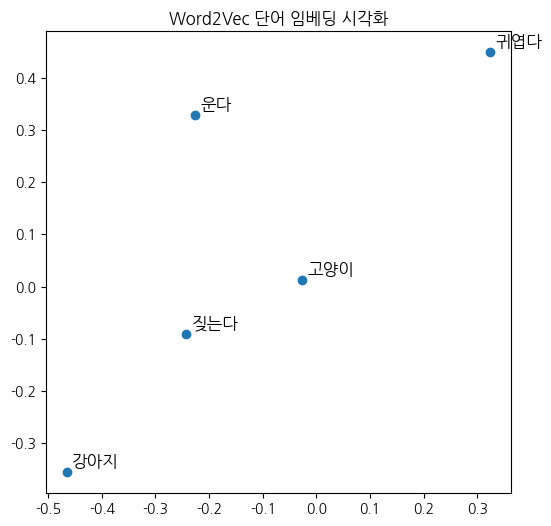

In [48]:
import matplotlib.pyplot as plt

# 단어 벡터 불러오기
words = ["강아지", "고양이", "짖는다", "운다", "귀엽다"]
vectors = np.array([model.wv[w] for w in words])

# 시각화
plt.figure(figsize=(6, 6))
plt.scatter(vectors[:, 0], vectors[:, 1])

for i, word in enumerate(words):
    plt.text(vectors[i, 0]+0.01, vectors[i, 1]+0.01, word, fontsize=12)

plt.title("Word2Vec 단어 임베딩 시각화")
plt.show()

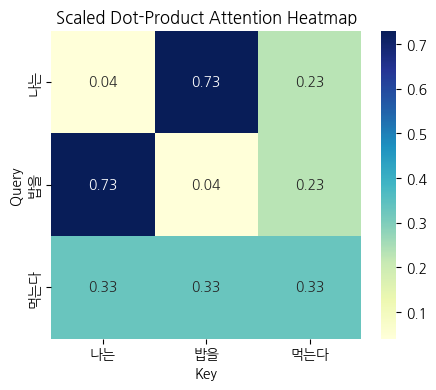

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 단어와 Softmax 가중치
words = ["나는", "밥을", "먹는다"]
attention = np.array([
    [0.04, 0.73, 0.23],
    [0.73, 0.04, 0.23],
    [0.33, 0.33, 0.33]
])

plt.figure(figsize=(5,4))
sns.heatmap(attention, annot=True, cmap="YlGnBu", xticklabels=words, yticklabels=words)
plt.title("Scaled Dot-Product Attention Heatmap")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()
